# Set up Conda Environment

In [ ]:
!git clone https://github.com/Microsoft/computervision-recipes


Cloning into 'computervision-recipes'...
remote: Enumerating objects: 6047, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 6047 (delta 264), reused 250 (delta 250), pack-reused 5767
Receiving objects: 100% (6047/6047), 258.62 MiB | 16.80 MiB/s, done.
Resolving deltas: 100% (3800/3800), done.


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda env list

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...
# conda environments:
#
base                  *  /usr/local



In [ ]:
!conda install pytorch==1.4.0 torchvision==0.5.0 cudatoolkit=10.0 -c pytorch -y
!conda install bqplot -y

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
- \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=10.0
    - pytorch==1.4.0
    - torchvision==0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    ca-certificates-2022.5.18.1|       ha878542_0         144 KB  conda-forge
    certifi-2022.5.18.1        |   py37h89c1867_0         150 KB  conda-forge
    conda-4.13.0               |   py37h89c1867_1         989 KB  conda-forg

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Load the libraries

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.append("./computervision-recipes")

import numpy as np
from pathlib import Path
#import scrapbook as sc

#fastai and torch
import fastai
from fastai.metrics import accuracy
from fastai.vision import ( models, ImageList, imagenet_stats, partial, cnn_learner, ClassificationInterpretation, to_np, )
from fastai.vision import *
from fastai.callbacks.hooks import *

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import db_num_workers, which_processor
from utils_cv.segmentation.data import Urls
from utils_cv.segmentation.dataset import read_classes
from utils_cv.segmentation.model import get_ratio_correct_metric, predict, confusion_matrix, print_accuracies
from utils_cv.segmentation.plot import plot_image_and_mask, plot_mask_stats, plot_segmentation, plot_confusion_matrix

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.61
Torch is using GPU: Tesla T4


In [ ]:
import os
import sys
import glob
from PIL import Image
from patchify import patchify
import PIL
import cv2

# Connect to Google Collab and Unzip the folder into drive
Leave the unzip part if folder is already created.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive"

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
!unzip "/content/drive/My Drive/pathologyData.zip" -d "/content/drive/My Drive/"

Archive:  /content/drive/MyDrive/pathologyData.zip
replace pathologyData/test/13591_500_f00006_original.out.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: pathologyData/test/13591_500_f00006_original.out.png  
  inflating: pathologyData/test/13591_500_f00006_original.tif  
  inflating: pathologyData/test/13616_500_f00087_original.out.png  
  inflating: pathologyData/test/13616_500_f00087_original.tif  
  inflating: pathologyData/test/13617_500_f00023_original.out.png  
  inflating: pathologyData/test/13617_500_f00023_original.tif  
  inflating: pathologyData/test/13687_500_f00001_original.out.png  
  inflating: pathologyData/test/13687_500_f00001_original.tif  
  inflating: pathologyData/test/13688_500_f00001_original.out.png  
  inflating: pathologyData/test/13688_500_f00001_original.tif  
  inflating: pathologyData/test/13689_500_f00011_original.out.png  
  inflating: pathologyData/test/13689_500_f00011_original.tif  
  inflating: pathologyData/test/13693_500_f00052_origin

# Assgin path to train and test folders in the drive

In [ ]:
#Used only in the case if we need to remove the complete folder. Or else no need.
#import shutil
#shutil.rmtree("/content/drive/MyDrive/pathologyData/pathdata/")

### create a new folder and perform image imputation

In [ ]:
ORG_TRAIN_PATH = '/content/drive/MyDrive/pathologyData/train/' #original train dataset
ORG_TEST_PATH = '/content/drive/MyDrive/pathologyData/test/'   #original test dataset

NEW_DATA_PATH = '/content/drive/MyDrive/pathologyData/pathdata/' #New folder to perform segmentation
IMAGE_PATH = '/content/drive/MyDrive/pathologyData/pathdata/images/' #all image folder 
MASK_PATH = '/content/drive/MyDrive/pathologyData/pathdata/segmentation-masks/' #all mask folder

# create required folders
path = Path(NEW_DATA_PATH)
if not path.exists():
  path.mkdir()

img_path = Path(IMAGE_PATH)
if not img_path.exists():
  img_path.mkdir()

test_seg_path = Path(MASK_PATH)
if not test_seg_path.exists():
  test_seg_path.mkdir()

In [ ]:
# Function to create patches for main images, of the size provided to function and create a valid.txt file for test images
def create_tile_image(filename, dir_in, dir_out, img_size, textfile):
  fname = str(filename).split("/")[-1].split(".")[0]
  image_read = cv2.imread(filename)
  patch_var = patchify(image_read, (img_size, img_size, 3), step = img_size)
  for i in range(patch_var.shape[0]):
    for j in range(patch_var.shape[1]):
      img_patch = patch_var[i, j, 0, :, :, :]
      path1 = dir_out + fname+ '_' + str(i) + str(j)+ ".tif"
      if dir_in == ORG_TEST_PATH:
        textfile.write(fname + '_' + str(i) + str(j)+ ".tif" + "\n")
      cv2.imwrite(dir_out + fname + '_' + str(i) + str(j)+ ".tif", img_patch)
      
# Function to create patches for mask images, of the size provided to function
def create_tile_mask(filename, dir_out, img_size):
  fname=str(filename).split("/")[-1].split(".")[0]
  image_read = cv2.imread(filename)
  grayscale = cv2.cvtColor(image_read, cv2.COLOR_BGR2GRAY)
  patch_var = patchify(grayscale, (img_size, img_size), step = img_size)
  for i in range(patch_var.shape[0]):
      for j in range(patch_var.shape[1]):
          img_patch = patch_var[i, j, :, :]
          cv2.imwrite(dir_out + fname + '_' + str(i) + str(j)+ ".png", img_patch)

In [ ]:
IMG_SLICE_SIZE = 200 # patch size defined for the images

train_images = sorted(glob.glob(ORG_TRAIN_PATH +"/*.tif")) #fetch all train images
test_images = sorted(glob.glob(ORG_TEST_PATH +"/*.tif")) #fetch all test images
seg_images = sorted(glob.glob(ORG_TRAIN_PATH +"/*.out.png")) #fetch all train masks
test_seg_images = sorted(glob.glob(ORG_TEST_PATH +"/*.out.png")) #fetch all test masks

for image in train_images:
    create_tile_image(image, ORG_TRAIN_PATH, IMAGE_PATH, IMG_SLICE_SIZE, '') # calling patch function

valpath = os.path.join(NEW_DATA_PATH, "valid.txt") # creating test file for segmentation
textfile = open(valpath, "w")

for t_image in test_images:
    create_tile_image(t_image, ORG_TEST_PATH, IMAGE_PATH, IMG_SLICE_SIZE, textfile) # calling patch function

textfile.close()

for seg_image in seg_images:
    create_tile_mask(seg_image, MASK_PATH, IMG_SLICE_SIZE) # calling patch function

for t_seg_image in test_seg_images:
    create_tile_mask(t_seg_image, MASK_PATH, IMG_SLICE_SIZE) # calling patch function

In [ ]:
len(os.listdir(IMAGE_PATH))
len(os.listdir(MASK_PATH))
#len(os.listdir(TEST_PATH))

8325

# Defining model variables and Performing Data checks

In [ ]:
# Path to data
DATA_PATH = '/content/drive/My Drive/pathologyData/pathdata/'

# Training parameters
EPOCHS = 8
LEARNING_RATE = 3e-4

# Reject all predictions with confidence lower than this threshold
THRESHOLD = None
IM_SIZE = np.array([100, 100])
ARCHITECTURE = models.vgg19_bn
BATCH_SIZE = 10


In [ ]:
DATA_PATH = Path(DATA_PATH)
DATA_PATH.ls()

[PosixPath('/content/drive/My Drive/pathologyData/pathdata/images'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/segmentation-masks'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/valid.txt')]

In [ ]:
im_path = DATA_PATH / "images"
im_paths = sorted(get_image_files(im_path))
im_paths[:3]

[PosixPath('/content/drive/My Drive/pathologyData/pathdata/images/10256_500_f00001_original_00.tif'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/images/10256_500_f00001_original_01.tif'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/images/10256_500_f00001_original_02.tif')]

In [ ]:
anno_path = DATA_PATH / "segmentation-masks"
mask_paths = sorted(get_image_files(anno_path))
mask_paths[:3]

[PosixPath('/content/drive/My Drive/pathologyData/pathdata/segmentation-masks/10256_500_f00001_original_00.png'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/segmentation-masks/10256_500_f00001_original_01.png'),
 PosixPath('/content/drive/My Drive/pathologyData/pathdata/segmentation-masks/10256_500_f00001_original_02.png')]

In [ ]:
get_gt_filename = lambda x: anno_path / f"{x.stem}.png"  # Function  to fetch all respective mask image of any image which will be later called in image segmentation

In [ ]:
#Creating Class Array
classes = ['void'] * 254
classes.append('foreground') # Setting foreground for 255
classes.insert(0,'background') # Setting background for 0
textfile = open(DATA_PATH / "classes.txt", "w")
for element in classes:
    textfile.write(element + "\n")
textfile.close()

In [ ]:
# Reading classes
classes_path = DATA_PATH / "classes.txt"
classes = np.loadtxt(classes_path, dtype=str)
classes

array(['background', 'void', 'void', 'void', ..., 'void', 'void', 'void', 'foreground'], dtype='<U10')

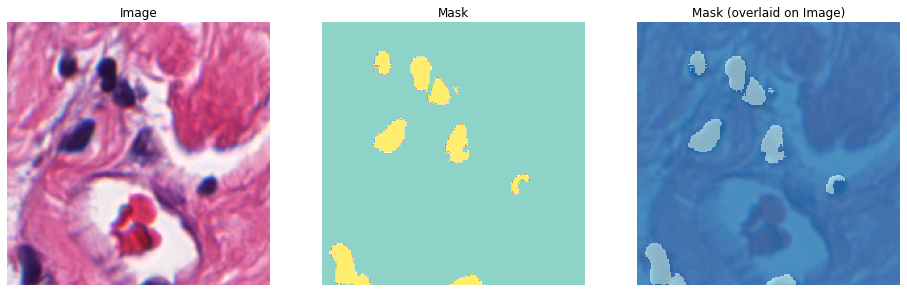

In [ ]:
# Plot images and masks
plot_image_and_mask(im_paths[0],mask_paths[0],  alpha=0.8)

# Image Segmentation Block

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
data = (
    SegmentationItemList.from_folder(im_path)
    .split_by_fname_file('../valid.txt')  #example how to implement a dedicated split 
    .label_from_func(get_gt_filename, classes=classes)
    .transform(get_transforms(), resize_method = ResizeMethod.CROP, size=IM_SIZE, tfm_y=True)
    .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
    .normalize(imagenet_stats)
)

In [ ]:
data.show_batch

<bound method DataBunch.show_batch of ImageDataBunch;

Train: LabelList (5925 items)
x: SegmentationItemList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: SegmentationLabelList
ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100)
Path: /content/drive/My Drive/pathologyData/pathdata/images;

Valid: LabelList (2400 items)
x: SegmentationItemList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: SegmentationLabelList
ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100),ImageSegment (1, 100, 100)
Path: /content/drive/My Drive/pathologyData/pathdata/images;

Test: None>

In [ ]:
print(f"Number of images: {len(data.y.items)}")
print(f"Classes: {data.classes}")

Number of images: 5925
Classes: ['background' 'void' 'void' 'void' ... 'void' 'void' 'void' 'foreground']


### Checking for void values in the classest.txt

In [ ]:
#Mapping void to unused class ID
class2id = {v:k for k,v in enumerate(data.classes)}
if 'void' in class2id:
  void_code = class2id['void']
else: 
  void_code = -100

class2id

{'background': 0, 'foreground': 255, 'void': 254}

In [ ]:
learn = unet_learner(
    data, 
    ARCHITECTURE, 
    wd=1e-2, 
    metrics=get_ratio_correct_metric([0,255])
)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,ratio_correct,time
0,0.213625,1.293434,0.881422,04:34
1,0.207497,0.181220,0.920118,04:33
2,0.170707,0.168751,0.925738,04:32
3,0.163298,0.156977,0.932886,04:31
4,0.161147,0.159685,0.931444,04:31
5,0.158110,0.149845,0.935958,04:31
6,0.156286,0.149891,0.935990,04:31
7,0.159106,0.148583,0.936339,04:31


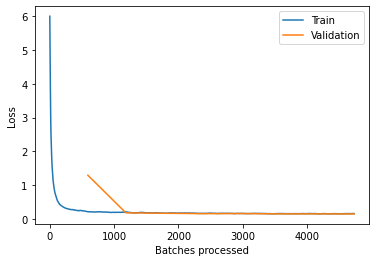

In [ ]:
learn.fit_one_cycle(EPOCHS, LEARNING_RATE) 
learn.recorder.plot_losses()

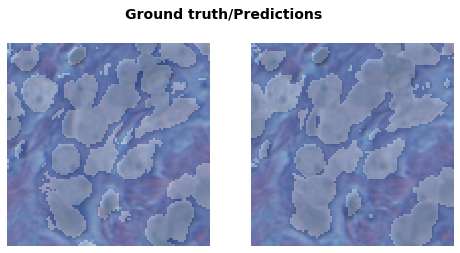

In [ ]:
learn.show_results(rows=1)

### Class wise accuracy. 0: Background, 255: Foreground

In [ ]:
cmat, cmat_norm = confusion_matrix(learn, data.valid_dl)
accs = print_accuracies(cmat, cmat_norm, [0,255])

Overall accuracy: 93.22%
Class-averaged accuracy: 89.62%
	Class               0 has accuracy: 95.47%
	Class             255 has accuracy: 83.76%
